In [1]:
# Import the necessary libraries
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shap
import sklearn

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Input dataset
dataset = pd.read_excel("data.xlsx")
dataset.head()
X = dataset.drop("g_r", axis = 1)
y = dataset.g_r


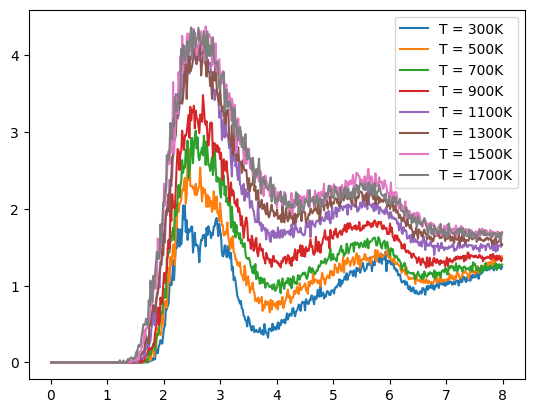

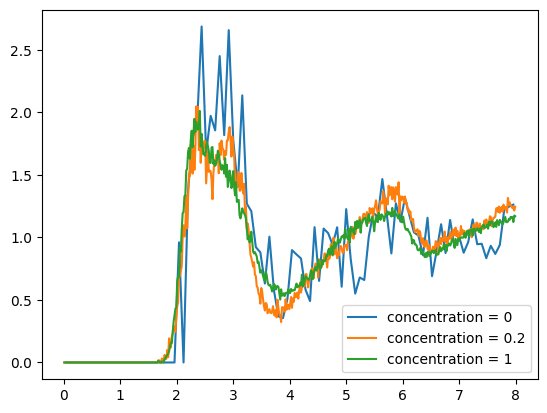

In [3]:
# Show MD simulation results
data_T = pd.read_excel("data_T.xlsx")
data_T.head()
T = [3, 5, 7, 9, 11, 13, 15, 17]
for i in T:
    data_Ti=data_T.loc[data_T['Temp'] == i*100]
    plt.plot(data_Ti['distance'], data_Ti['g_r'], label=f'T = {i*100}K')
plt.legend(loc='upper right', fontsize='medium')
plt.show()

data_C = pd.read_excel("data_C.xlsx")
data_C.head()
C = [0, 0.2, 1]
for i in C:
    data_Ci=data_C.loc[data_C['concentration'] == i]
    plt.plot(data_Ci['distance'], data_Ci['g_r'], label=f'concentration = {i}')
plt.legend(loc='lower right', fontsize='medium')
plt.show()


The figure layout has changed to tight


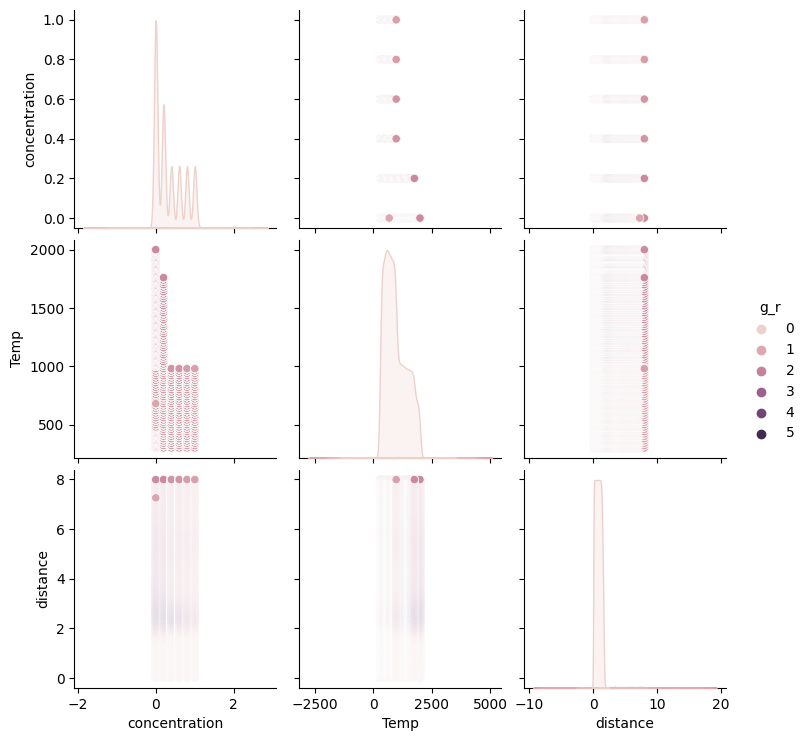

In [4]:
# Show the pairplot
sns.pairplot(dataset, hue="g_r")
plt.show()

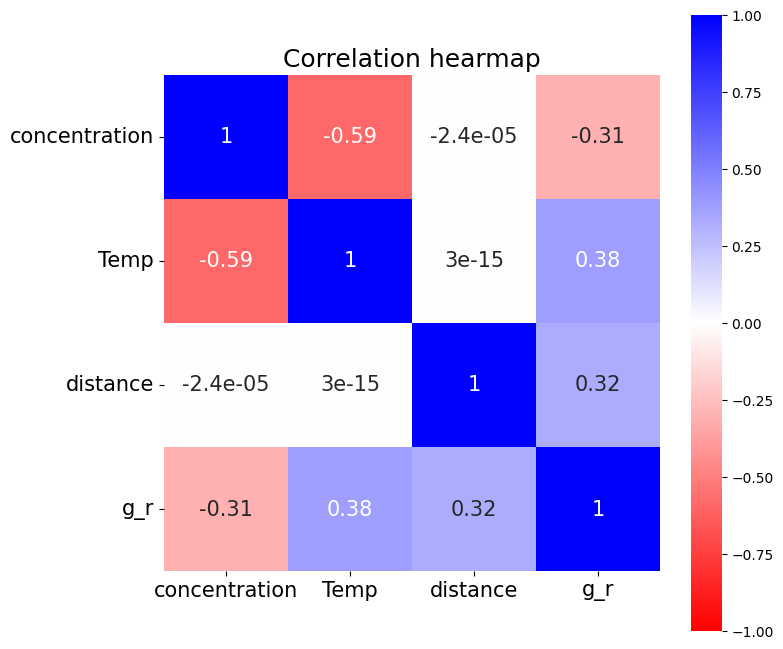

In [5]:
# Show the heatmap matrix
corr = dataset.corr()

plt.figure(figsize=(8, 8))
ax = sns.heatmap(corr, vmin=-1, vmax=1, square=True, annot=True, xticklabels=True, yticklabels=True, annot_kws={"size": 15}, cmap='bwr_r')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15) 
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, rotation=0) 
plt.title('Correlation hearmap', fontsize=18)
plt.show()

In [6]:
# Build baseline model
X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor_b = RandomForestRegressor(random_state=0)
regressor_b.fit(X_baseline_train, y_baseline_train)
y_baseline_pred = regressor_b.predict(X_baseline_test)
mse_baseline = mean_squared_error(y_baseline_test, y_baseline_pred)
rmse_baseline = mean_squared_error(y_baseline_test, y_baseline_pred, squared=False)
mae_baseline = mean_absolute_error(y_baseline_test, y_baseline_pred)
r2_baseline = r2_score(y_baseline_test, y_baseline_pred)
print(f'Baseline model scores:\nMSE = {mse_baseline:.10f}\nRMSE = {rmse_baseline:.4f}\nMAE = {mae_baseline:.10f}\nR Squared = {r2_baseline:.10f}')

Baseline model scores:
MSE = 0.0089214047
RMSE = 0.0945
MAE = 0.0538073223
R Squared = 0.9917414390


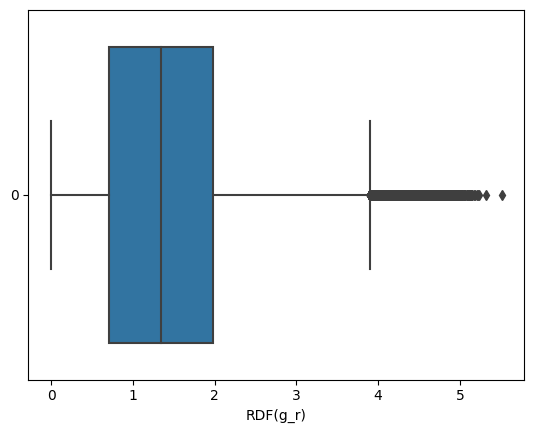

Old Shape:  (171900, 4)
New Shape:  (165991, 4)


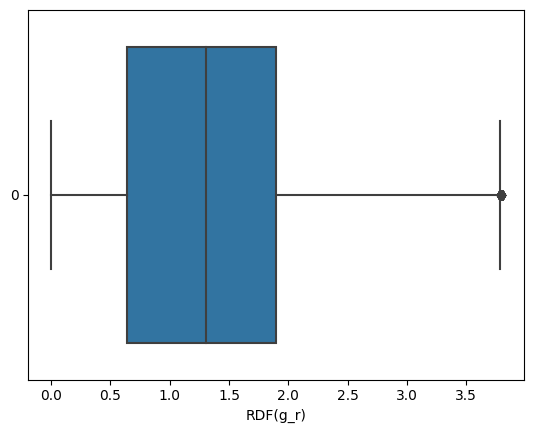

In [3]:
# Data preprocessing
# Plot the old data
sns.boxplot(dataset['g_r'], orient='h')
plt.xlabel('RDF(g_r)')
plt.show()

# Detection outlier
# IQR
Q1 = np.percentile(dataset['g_r'], 25,
                   method = 'midpoint')
 
Q3 = np.percentile(dataset['g_r'], 75,
                   method = 'midpoint')
IQR = Q3 - Q1

print("Old Shape: ", dataset.shape)

# Remove outlier
# Upper bound
upper = np.where(dataset['g_r'] > ((Q3 + 1.5 * IQR)-0.1))
# Lower bound
lower = np.where(dataset['g_r'] < (Q1 - 1.5 * IQR))

dataset.drop(upper[0], inplace = True)
dataset.drop(lower[0], inplace = True)

print("New Shape: ", dataset.shape)

# Plot the new data
sns.boxplot(dataset['g_r'], orient='h')
plt.xlabel('RDF(g_r)')
plt.show()

X = dataset.drop("g_r", axis = 1)
y = dataset.g_r

Tuned RF Regression Parameters: {'max_depth': 20, 'max_features': 1, 'n_estimators': 500}
Best score is 0.992752350438613


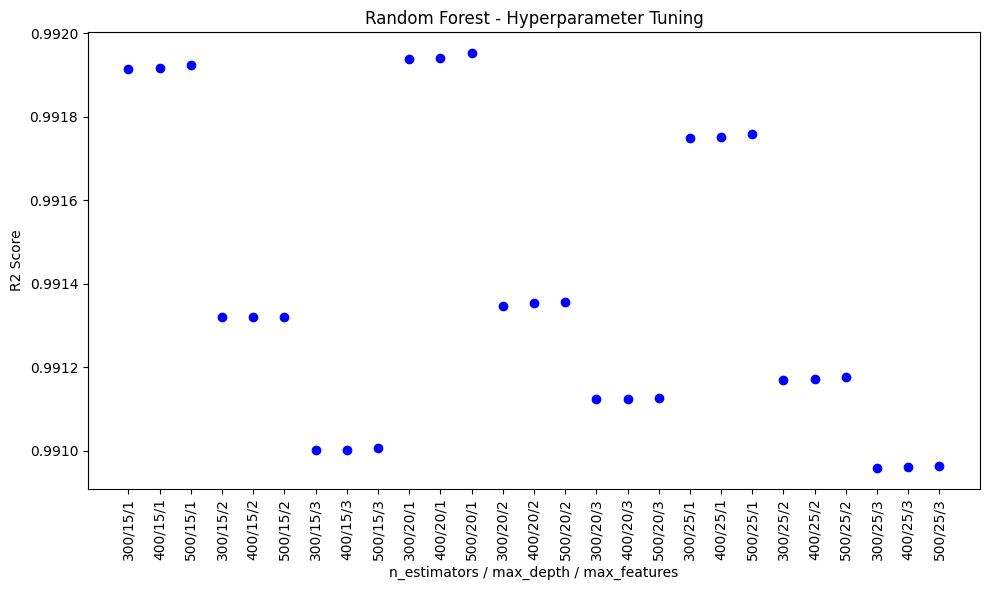

In [14]:
# Hyperparameter tuning 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = RandomForestRegressor(random_state=0)

# Define the parameter grid
param_grid = {'n_estimators': [300, 400, 500], 
              'max_depth': [15, 20, 25],
              'max_features': [1, 2, 3]
             }

# Initialize the grid search object
grid = GridSearchCV(regressor, param_grid, cv=5, scoring='r2')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Make predictions on the test set
rf_best_model = grid.best_estimator_
y_pred = rf_best_model.predict(X_test)
r2=r2_score(y_test, y_pred)
results=grid.cv_results_
params = results['params']
mean_test_scores = results['mean_test_score']

# Print the tuned parameters and score
print("Tuned RF Regression Parameters: {}".format(grid.best_params_))
print("Best score is {}".format(r2))

# Plot mean_test_score
plt.figure(figsize=(10, 6))
for param, score in zip(params, mean_test_scores):
    n_estimators = param['n_estimators']
    max_depth = param['max_depth']
    max_features = param['max_features']
    plt.scatter(f"{n_estimators}/{max_depth}/{max_features}", score, color='blue')

plt.xlabel('n_estimators / max_depth / max_features')
plt.ylabel('R2 Score')
plt.title('Random Forest - Hyperparameter Tuning')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Tuned RF Regression Parameters: {'max_depth': 17, 'max_features': 1, 'n_estimators': 500}
Best score is 0.9929852568161202


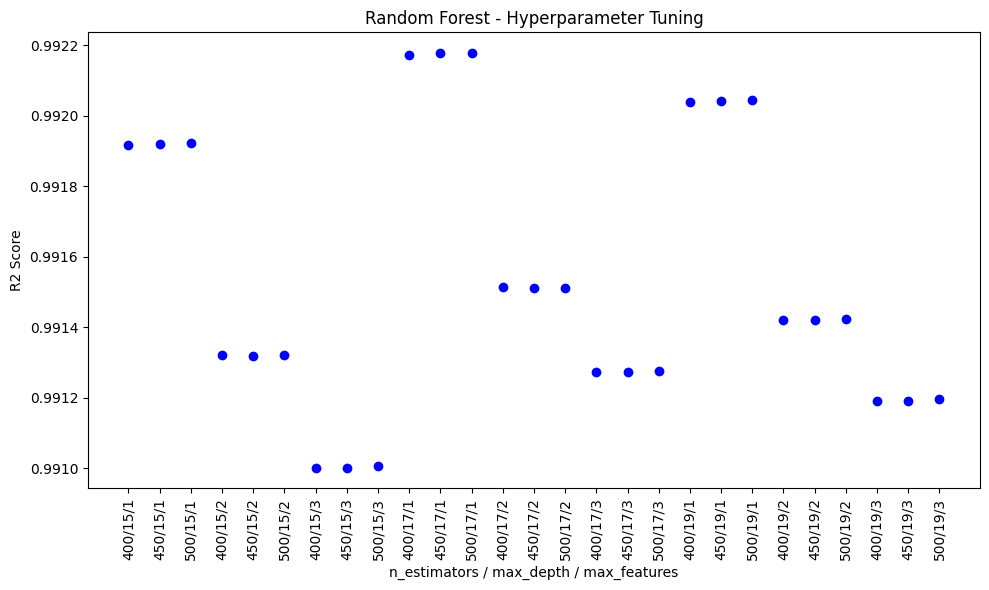

In [15]:
# Hyperparameter tuning 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = RandomForestRegressor(random_state=0)

# Define the parameter grid
param_grid = {'n_estimators': [400, 450, 500], 
              'max_depth': [15, 17, 19],
              'max_features': [1, 2, 3]
             }

# Initialize the grid search object
grid = GridSearchCV(regressor, param_grid, cv=5, scoring='r2')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Make predictions on the test set
rf_best_model = grid.best_estimator_
y_pred = rf_best_model.predict(X_test)
r2=r2_score(y_test, y_pred)
results=grid.cv_results_
params = results['params']
mean_test_scores = results['mean_test_score']

# Print the tuned parameters and score
print("Tuned RF Regression Parameters: {}".format(grid.best_params_))
print("Best score is {}".format(r2))

# Plot mean_test_score
plt.figure(figsize=(10, 6))
for param, score in zip(params, mean_test_scores):
    n_estimators = param['n_estimators']
    max_depth = param['max_depth']
    max_features = param['max_features']
    plt.scatter(f"{n_estimators}/{max_depth}/{max_features}", score, color='blue')

plt.xlabel('n_estimators / max_depth / max_features')
plt.ylabel('R2 Score')
plt.title('Random Forest - Hyperparameter Tuning')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


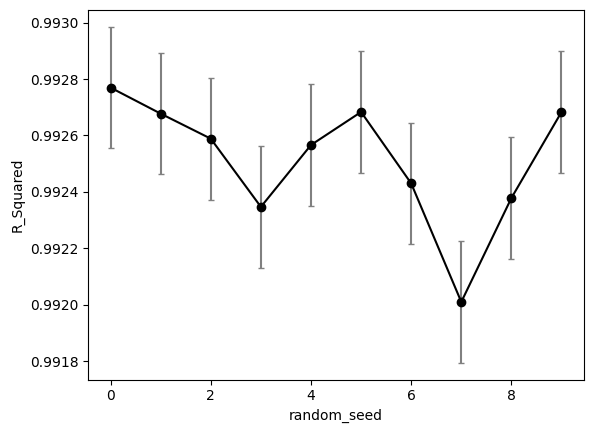

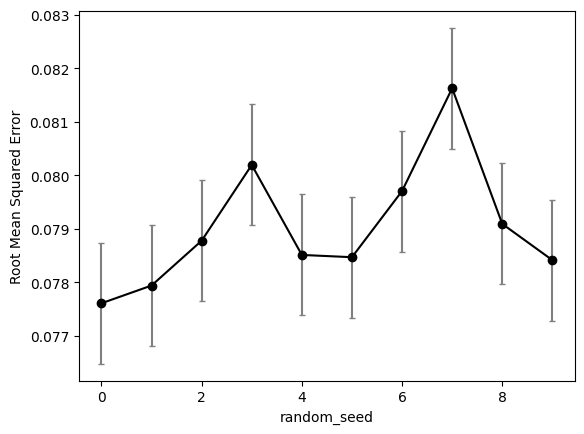

In [16]:
rmses = []
r2s = []
random_seed=np.arange(10)
for i in random_seed:
    X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y, test_size=0.2, random_state= random.randint(1,100000))
    rf_r_e = RandomForestRegressor(n_estimators = 450, max_depth=17, max_features= 1, random_state = random.randint(1,100000))
    rf_r_e.fit(X_train_e, y_train_e)
    y_pred_e = rf_r_e.predict(X_test_e)
    rmse = mean_squared_error(y_test_e, y_pred_e, squared=False)
    rmses.append(rmse)
    r2 = r2_score(y_test_e, y_pred_e)
    r2s.append(r2)

# visualize the results
plt.figure()
plt.errorbar(random_seed, r2s, yerr = np.std(r2s), fmt='o', color='black', ecolor='gray',capsize=2)
plt.plot(random_seed, r2s, color='black')
plt.xlabel('random_seed')
plt.ylabel('R_Squared')
plt.show()

plt.figure()
plt.errorbar(random_seed, rmses, yerr = np.std(rmses), fmt='o', color='black', ecolor='gray',capsize=2)
plt.plot(random_seed, rmses, color='black')
plt.xlabel('random_seed')
plt.ylabel('Root Mean Squared Error')
plt.show()

In [ ]:
print(max(r2s))
print(min(r2s))
print(max(rmses))
print(min(rmses))

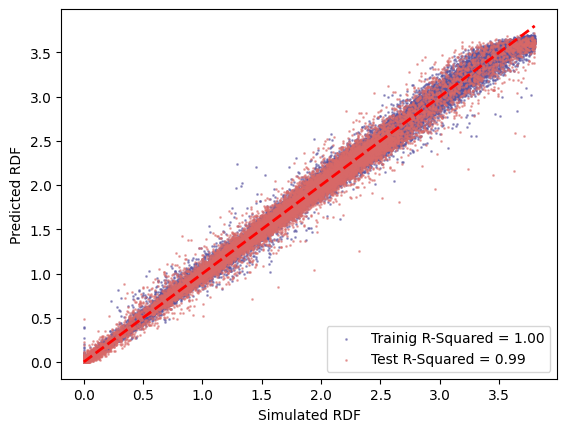

Mean Squared Error: 0.0058364042297859445
Root Mean Squared Error: 0.07639636267379452
Mean Absolute Error: 0.0447206600934395
R-squared: 0.9929852568161202


In [4]:
# Evaluate the model's performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = RandomForestRegressor(n_estimators=500, max_depth=17, max_features=1, random_state=0)
regressor.fit(X_train, y_train)

y_train_pred= regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

plt.scatter(y_train, y_train_pred, alpha=0.5, label = f'Trainig R-Squared = {r2_train:.2f}', s =1, c='#58539f')
plt.scatter(y_test, y_test_pred, alpha=0.5, label = f'Test R-Squared = {r2_test:.2f}', s =1, c='#d86967' )
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red', linewidth=2)
plt.xlabel('Simulated RDF')
plt.ylabel('Predicted RDF')
legend = plt.legend(loc='lower right', fontsize='medium')
plt.show()

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


In [ ]:
data_pred_plot1 = pd.read_excel("data_pred_plot.xlsx")
data_pred_plot1.head()
X1 = data_pred_plot1.drop("g_r", axis = 1)
X2 = X1.drop("pred_g_r", axis = 1)
y_pred_all=regressor.predict(X2)
data_pred = pd.DataFrame(y_pred_all)

writer = pd.ExcelWriter("output0.xlsx")
data_pred.to_excel(writer, sheet_name="Sheet1")

workbook = writer.book
worksheet = writer.sheets["Sheet1"]

writer.close()

In [ ]:
data_pred_plot = pd.read_excel("data_pred_plot.xlsx")
data_pred_plot.head()
Tp = [300, 2000]
for i in [0, 1]:
    data_pred_ploti=data_pred_plot.loc[data_pred_plot['Temp'] == Tp[i]]
    plt.plot(data_pred_ploti['distance'], data_pred_ploti['g_r'], label=f'original T = {Tp[i]}K C = {1-i}')
    plt.plot(data_pred_ploti['distance'], data_pred_ploti['pred_g_r0'], label=f'pred T = {Tp[i]}K C = {1-i}')
plt.legend(loc='upper right', fontsize='medium')
plt.ylabel('RDF(g_r)')
plt.xlabel('distance')
plt.title('Original and RF prediction Li - Li RDF Curve\nat different temperature and concentration(x)')
plt.show()

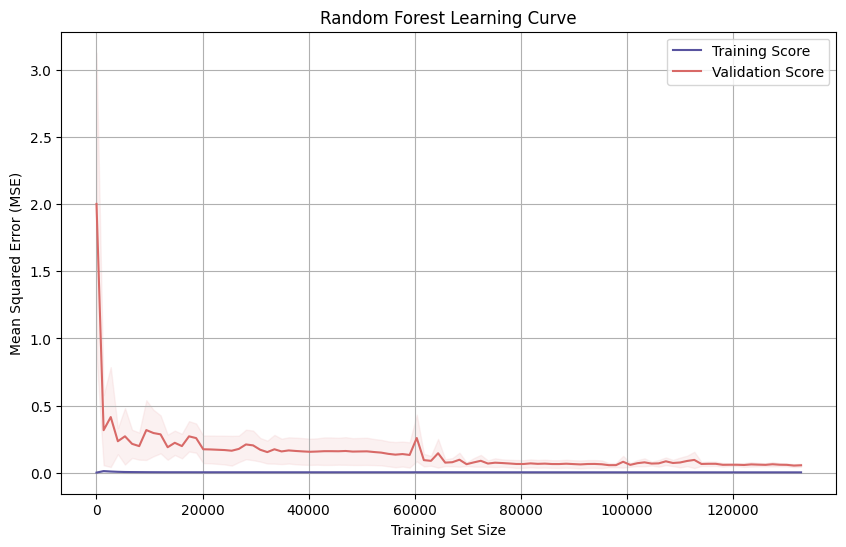

In [5]:
# Plot Learning Curve
train_sizes = np.linspace(0.0001, 1.0, 100)
train_sizes, train_scores, val_scores = learning_curve(
    regressor, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error', random_state=0
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='#58539f')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='#bbbbd6')
plt.plot(train_sizes, val_scores_mean, label='Validation Score', color='#d86967')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='#eebabb')

plt.title('Random Forest Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


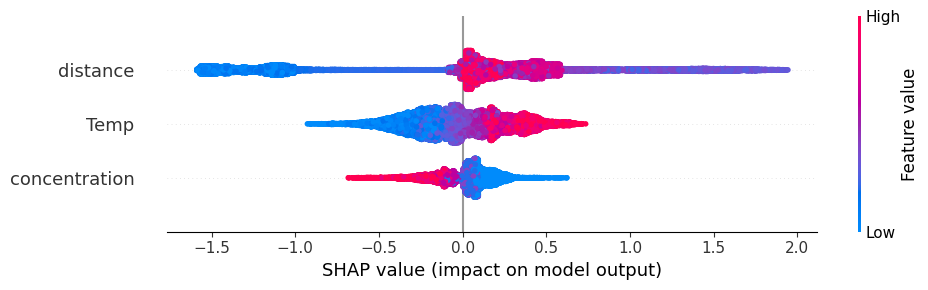

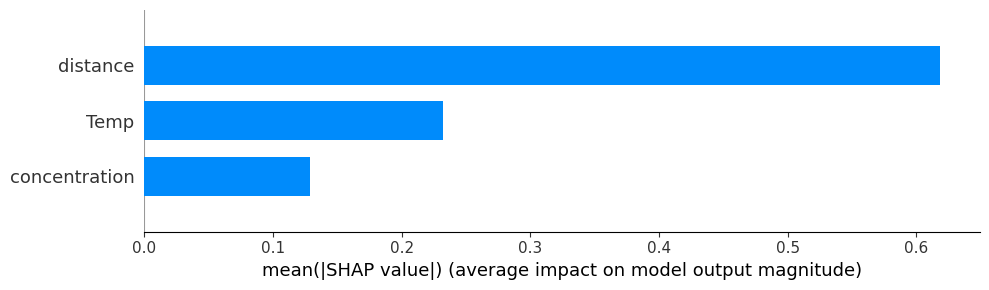

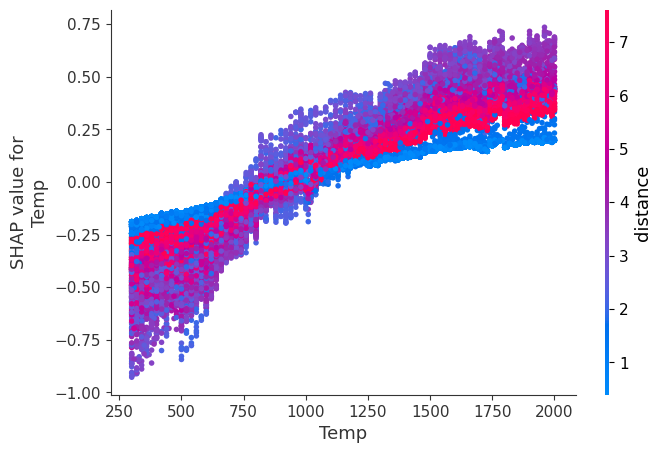

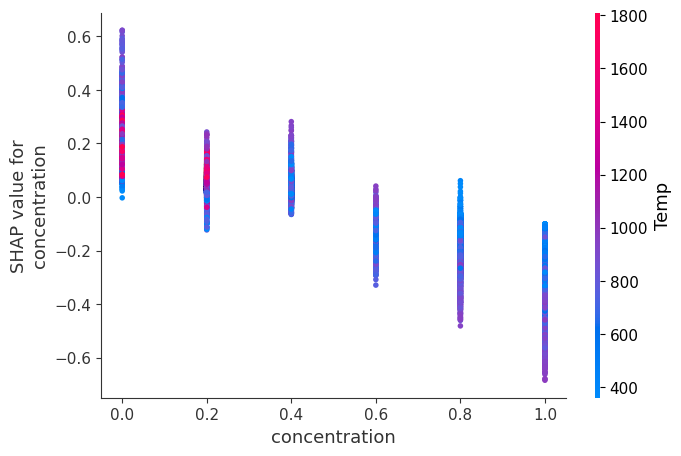

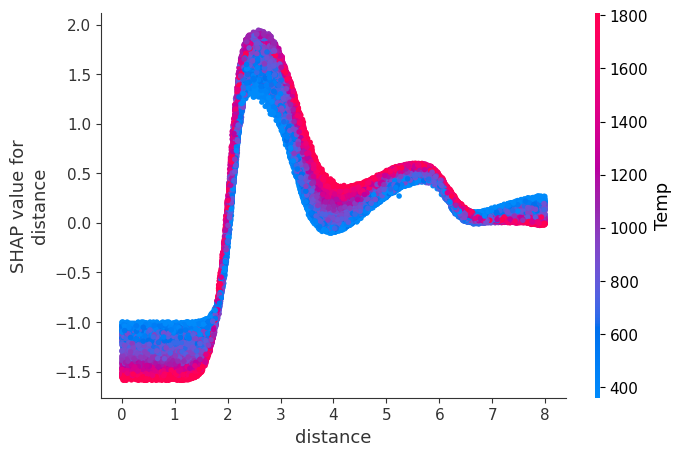

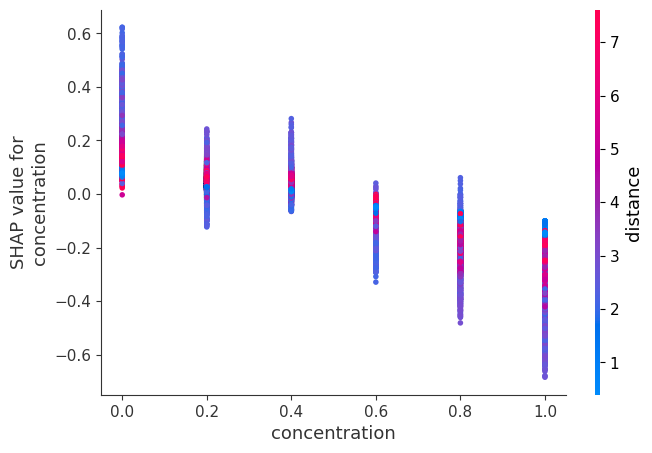

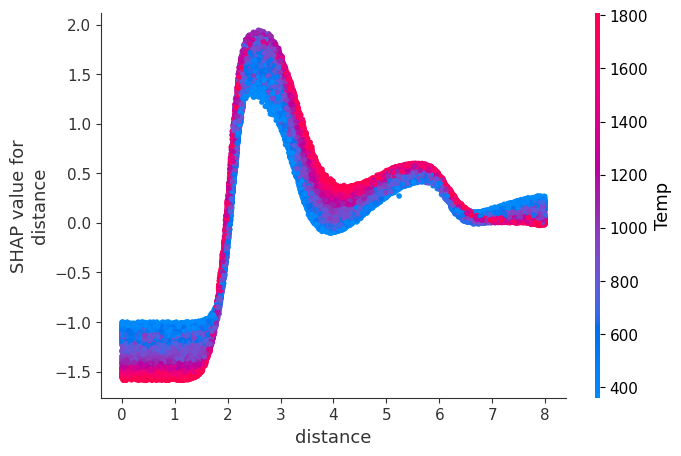

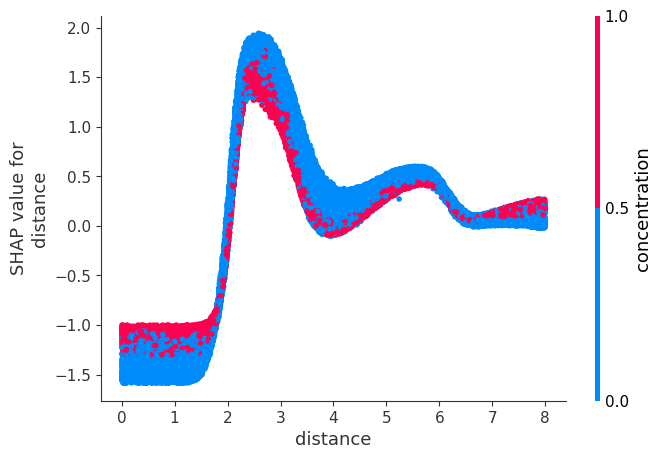

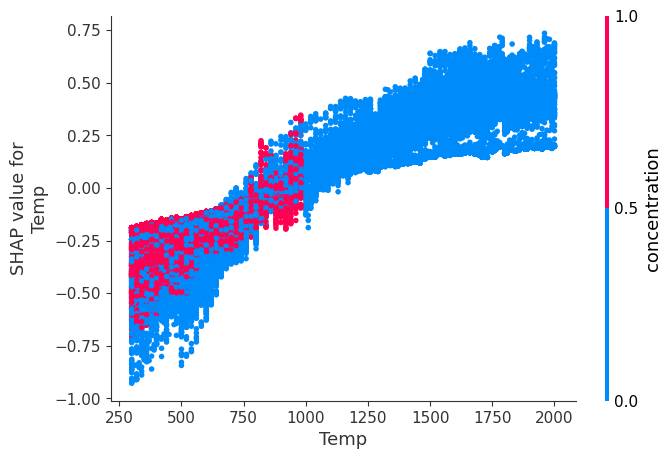

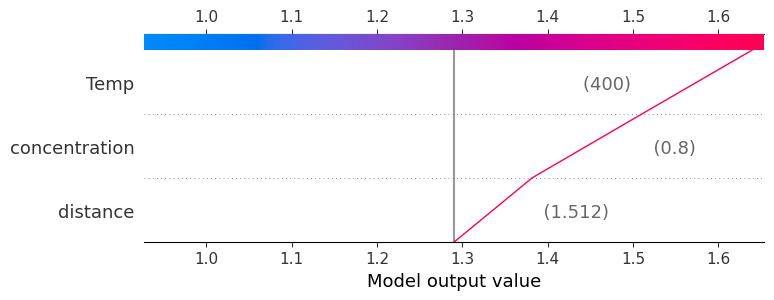

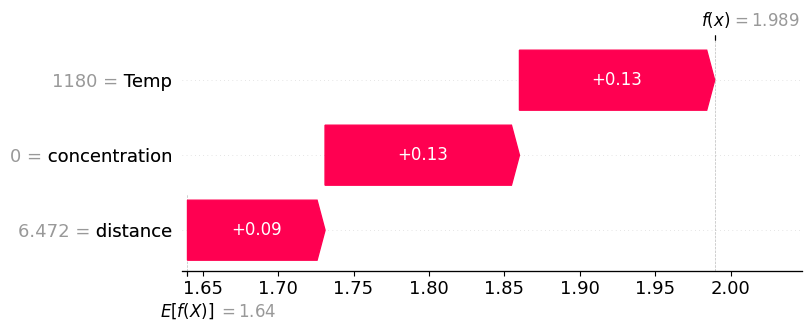

In [6]:
#Plot shap
explainer1 = shap.Explainer(regressor)

shap_values1 = explainer1.shap_values(X_test)

shap.summary_plot(shap_values1, X_test, plot_size=(10,3))

shap.summary_plot(shap_values1, X, plot_type="bar", plot_size=(10,3))

# Get the top 3 features based on their mean absolute SHAP values
top_3_features = pd.DataFrame(shap_values1).abs().mean().nlargest(3).index


# Plot dependence plot for each of the top 3 features and save it
shap.dependence_plot("Temp", shap_values1, X_test, interaction_index="distance")
shap.dependence_plot("concentration", shap_values1, X_test)
shap.dependence_plot("distance", shap_values1, X_test)
shap.dependence_plot("concentration", shap_values1, X_test, interaction_index="distance")

# Plot interaction values between the top 3 feature pairs and save them
for i in range(len(top_3_features)):
    for j in range(i+1, len(top_3_features)):
        feature_interaction1 = top_3_features[i]
        feature_interaction2 = top_3_features[j]
        interaction_plot = shap.dependence_plot(feature_interaction1, shap_values1, X_test, interaction_index=feature_interaction2)

# Plot force plot for a single prediction and save it
index_to_explain = 42  # You can change this index to explain different test samples
shap.initjs()
force_plot = shap.force_plot(explainer1.expected_value, shap_values1[index_to_explain], X_test.iloc[index_to_explain])
shap.save_html("force_plot1.html", force_plot)

# Plot interaction summary plot and save it
#interaction_summary_plot = shap.summary_plot(explainer1.shap_interaction_values(X_test), X_test)

 # Plot decision plot for a single prediction and save it
decision_plot = shap.decision_plot(explainer1.expected_value, shap_values1[index_to_explain], X_test.iloc[0,:])

# Create an Explanation object for the single prediction
exp = shap.Explanation(shap_values1[index_to_explain], y_pred[index_to_explain], X_test.iloc[index_to_explain])

# Plot the waterfall plot
shap.plots.waterfall(exp)